# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable for treatment status

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1:

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

**Answer.**

---------

In [3]:
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
len(lalonde_df[lalonde_df.re74 > lalonde_df.re75])*100/len(lalonde_df)

46.416938110749186

In [5]:
lalonde_df[lalonde_df.re74 > lalonde_df.re75]

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW110,1,26,10,1,0,1,1,2027.99900,0.00000,0.0000
NSW111,1,20,9,1,0,0,1,6083.99400,0.00000,8881.6650
NSW112,1,17,9,0,1,0,1,445.17040,74.34345,6210.6700
NSW113,1,20,12,1,0,0,0,989.26780,165.20770,0.0000
NSW114,1,18,11,1,0,0,1,858.25430,214.56360,929.8839
...,...,...,...,...,...,...,...,...,...,...
PSID358,0,16,7,0,1,0,1,289.97150,0.00000,7515.7170
PSID359,0,21,11,0,0,1,1,246.86760,0.00000,6708.8790
PSID360,0,55,6,0,0,1,1,111.67820,0.00000,0.0000
PSID361,0,37,12,0,0,0,0,48.98167,0.00000,877.7696


- We see a great reduction in the average income between 1974 and 1975
- 46% of the population reduced their income between 1974 and 1975
- Economic recession in the 70's

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.**

In [6]:
from   scipy import stats

In [7]:
treatment=lalonde_df[lalonde_df.treat==1]
control=lalonde_df[lalonde_df.treat==0]

In [8]:
len(treatment)*100/len(lalonde_df)

30.13029315960912

In [9]:
print(treatment.re74.mean()-control.re74.mean())
print(treatment.re74.median()-control.re74.median())
## A simple t test for difference of means
t2, p2 = stats.ttest_ind(treatment.re74,control.re74)
print("t = " + str(t2))
print("p = " + str(p2))

-3523.6628177382977
-2547.047
t = -6.381464485508746
p = 3.464585257757616e-10


In [10]:
print(treatment.re75.mean()-control.re75.mean())
print(treatment.re75.median()-control.re75.median())
## A simple t test for difference of means
t2, p2 = stats.ttest_ind(treatment.re75,control.re75)
print("t = " + str(t2))
print("p = " + str(p2))

-934.4291293397591
-1086.726
t = -3.2485513845081773
p = 0.0012234443948498416


In [11]:
print(treatment.re78.mean()-control.re78.mean())
print(treatment.re78.median()-control.re78.median())
## A simple t test for difference of means
t2, p2 = stats.ttest_ind(treatment.re78,control.re78)
print("t = " + str(t2))
print("p = " + str(p2))

-635.0262120374209
-743.1959999999999
t = -0.9663522254463778
p = 0.3342496685909654


In [12]:
print(treatment.re74.mean())
print(treatment.re75.mean())
print(treatment.re78.mean())

2095.573688648649
1532.0553137837837
6349.143530270271


In [13]:
print(control.re74.mean())
print(control.re75.mean())
print(control.re78.mean())

5619.2365063869465
2466.484443123543
6984.169742307692


- 30% of the population is part of the group under treatment

---------

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**

The treatment had a positive impact, since people in this group on average increased their income from 1974 to 1978

---------

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2:

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.**

In [14]:
def SMD(treatment,control):
    smd=abs((treatment.mean()-control.mean())/(np.sqrt((treatment.std()**2 + control.std()**2)/2)))
    return smd

In [15]:
SMD(treatment.age,control.age)

0.24190362292609968

In [16]:
names=treatment.columns
smd=pd.DataFrame()
for name in names:
    smd[name]= [SMD(treatment[name],control[name])]
smd

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,inf,0.241904,0.044755,1.667719,0.27694,0.719492,0.235048,0.595752,0.287002,0.083708


'age', 'black', 'hispan', 'married', 'nodegree','re74', 're75' are imbalaced

---------

#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.**

In [17]:
control.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

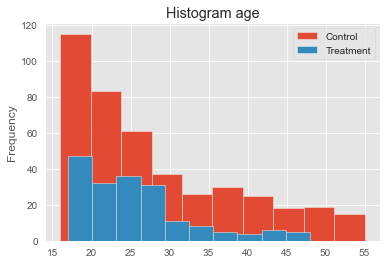

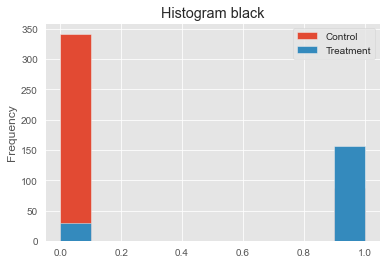

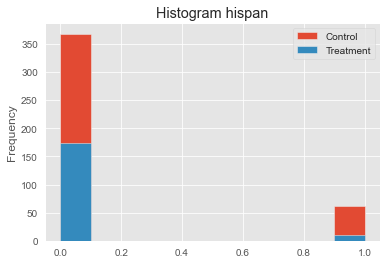

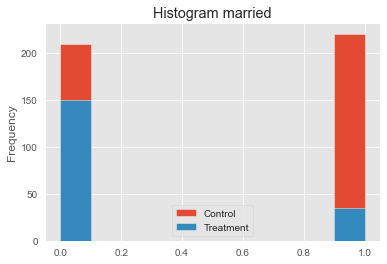

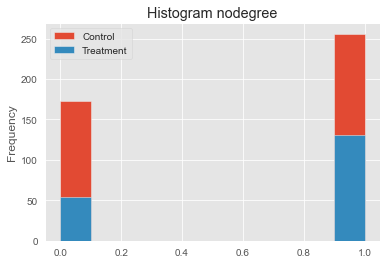

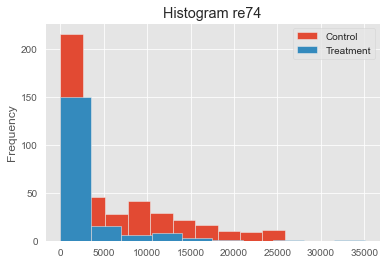

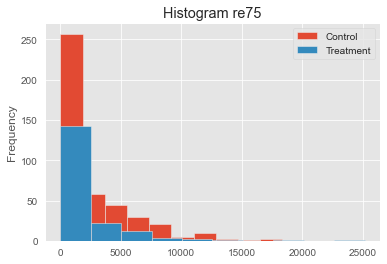

In [18]:
labels=['age', 'black', 'hispan', 'married', 'nodegree','re74', 're75',]
for l in labels:
    plt.figure()
    control[l].plot.hist(label='Control')
    treatment[l].plot.hist(label='Treatment')
    plt.title("Histogram " + l)
    plt.legend()

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3:

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.**

In [19]:
lalonde_copy=lalonde_df.copy()
lalonde_copy['Intercept'] = 1
lalonde_copy['re74']=(lalonde_copy['re74']-lalonde_copy['re74'].mean())/lalonde_copy['re74'].std()
lalonde_copy['re75']=(lalonde_copy['re75']-lalonde_copy['re75'].mean())/lalonde_copy['re75'].std()
logit = sm.Logit(lalonde_copy['treat'], lalonde_copy[['Intercept','age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']])
logit_res = logit.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:                  0.3508
Time:                        10:06:06   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9390      1.026     -4.815      0.000      -6.950      -2.928
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74          -0.4650      0.186     -2.497      0.013      -0.830      -0.100
re75           0.1761      0.153      1.153      0.249      -0.123       0.476
==============================================================================
"""

In [20]:
lalonde_df.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

Each of the covariates in the model gives us information on the probability that the person is in the control group or in the treatment group, since negative values indicate that they are less likely to be part of the treatment group.

- The intercept gives us an initial value of probability with a high negative value, initially indicating that without knowing the other variables it is more likely that they are not part of the treatment group.
- Age, education, hispanic, nodegree, re75 have positive coefficients indicating that the higher the values of these variables, the more likely they belong to the treatment group. The variable black has a high positive coefficient thus giving a high probability that they belong to the treatment group if a person is black skinned
- Married and re74, are variables with negative coefficients indicating the opposite of the previous variables.

---------

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.**

In [21]:
pscore_logit=logit_res.predict(lalonde_copy[['Intercept','age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']]).reset_index().rename(columns={0:'pscore'})
pscore_logit

,index,pscore
0,NSW1,0.638770
1,NSW2,0.224634
2,NSW3,0.678244
3,NSW4,0.776324
4,NSW5,0.701639
...,...,...
609,PSID425,0.123144
610,PSID426,0.034560
611,PSID427,0.183351
612,PSID428,0.383032


Text(0.5, 1.0, 'pscores for the Control Group')

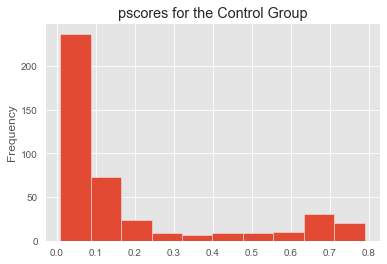

In [22]:
control=control.merge(pscore_logit,left_index=True,right_on='index')
control.pscore.plot.hist()
plt.title('pscores for the Control Group')

Text(0.5, 1.0, 'pscores for the treatment Group')

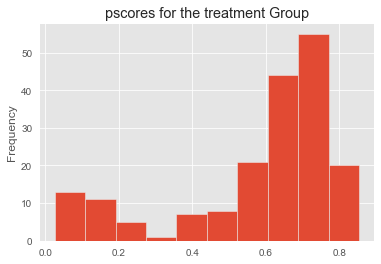

In [23]:
treatment=treatment.merge(pscore_logit,left_index=True,right_on='index')
treatment.pscore.plot.hist()
plt.title('pscores for the treatment Group')

---------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4:

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.**

In [24]:
treat_pscores=treatment.pscore
control_pscores=control.pscore
knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(np.array(control_pscores).reshape(-1,1))


NearestNeighbors(metric='euclidean')

---------

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

**Answer.**

In [25]:
neigh=knn.kneighbors(np.array(treat_pscores).reshape(-1,1))[1]


---------

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.**

In [26]:
matched=pd.DataFrame()
for n in neigh:
    matched=matched.append(lalonde_df.loc[control.iloc[[n[0]]]['index']])
matched

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
PSID69,0,30,17,1,0,0,0,17827.37000,5546.4190,14421.1300
PSID111,0,51,11,0,0,0,1,48.98167,3813.3870,1525.0140
PSID370,0,16,9,1,0,0,1,0.00000,0.0000,2158.9590
PSID226,0,39,10,1,0,0,1,844.44400,889.7903,701.9201
PSID140,0,19,9,1,0,0,1,1079.55600,2873.4680,14344.2900
...,...,...,...,...,...,...,...,...,...,...
PSID239,0,18,11,0,1,0,1,0.00000,630.1935,0.0000
PSID76,0,26,12,0,1,0,0,7968.33800,5109.5810,4181.9660
PSID380,0,34,12,1,0,1,0,0.00000,0.0000,18716.8800
PSID24,0,47,8,1,0,1,1,9275.16900,8543.4190,0.0000


In [27]:
#Previously create this Df in ex 3.2
treatment=treatment.set_index('index')

In [28]:
treatment

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,pscore
index,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.00,0.00,9930.0460,0.638770
NSW2,1,22,9,0,1,0,1,0.00,0.00,3595.8940,0.224634
NSW3,1,30,12,1,0,0,0,0.00,0.00,24909.4500,0.678244
NSW4,1,27,11,1,0,0,1,0.00,0.00,7506.1460,0.776324
NSW5,1,33,8,1,0,0,1,0.00,0.00,289.7899,0.701639
...,...,...,...,...,...,...,...,...,...,...,...
NSW181,1,33,12,1,0,1,0,20279.95,10941.35,15952.6000,0.287016
NSW182,1,25,14,1,0,1,0,35040.07,11536.57,36646.9500,0.149168
NSW183,1,35,9,1,0,1,1,13602.43,13830.64,12803.9700,0.494681


---------

### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5:

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

**Answer.**

---------

Text(0.5, 1.0, 'pscores for the treatment Group')

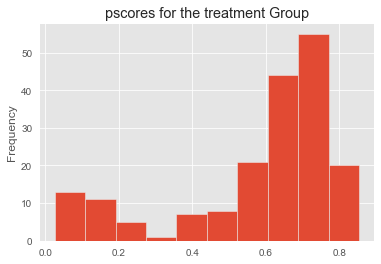

In [29]:
treatment.pscore.plot.hist()
plt.title('pscores for the treatment Group')

Text(0.5, 1.0, 'pscores for the matches control Group')

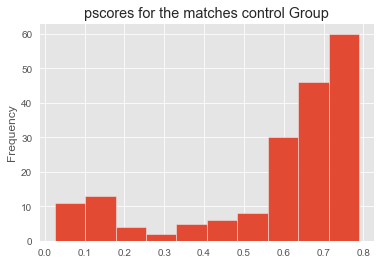

In [30]:
matched=matched.merge(pscore_logit,left_index=True,right_on='index')
matched.pscore.plot.hist()
plt.title('pscores for the matches control Group')

### Exercise 6:

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

In [31]:
def ASMD(treatment,control,matched):
    smd=abs((treatment.mean()-matched.mean())/(np.sqrt((treatment.std()**2 + control.std()**2)/2)))
    return smd

In [32]:
names

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

In [33]:
names=treatment.columns[:-1]
asmd=pd.DataFrame()
for name in names:
    asmd[name]= [ASMD(treatment[name],control[name],matched[name])]
asmd

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,inf,0.187213,0.013134,0.014076,0.018094,0.132189,0.011408,0.040728,0.008639,0.233907


With the matching that was performed we can see that now all the variables are balanced except for re78

---------

### Exercise 7:

Estimate the average effect of treatment on <font color='red'> wages (`re78`) </font> after matching. What do you conclude?

**Answer.**

In [34]:
## A simple t test for difference of means
t2, p2 = stats.ttest_ind(treatment.re78,matched.re78)
print("t = " + str(t2))
print("p = " + str(p2))

t = 2.50360661035708
p = 0.012725784509926862


Thanks to the t test we can conclude that the average of re74 between these two groups is different, but it must be taken into account that this variable is not balanced according to the result in the previous excercise.

---------

## Propensity score matching using decision trees and random forests

### Exercise 8:

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.**

In [35]:
treeclf = tree.DecisionTreeClassifier(max_depth = 4)

# Train Decision Tree Classifer


treeclf = treeclf.fit(lalonde_df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']], lalonde_df['treat'])

In [36]:
pscore_tree=treeclf.predict_proba(lalonde_copy[['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']])[:,1]

---------

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.**

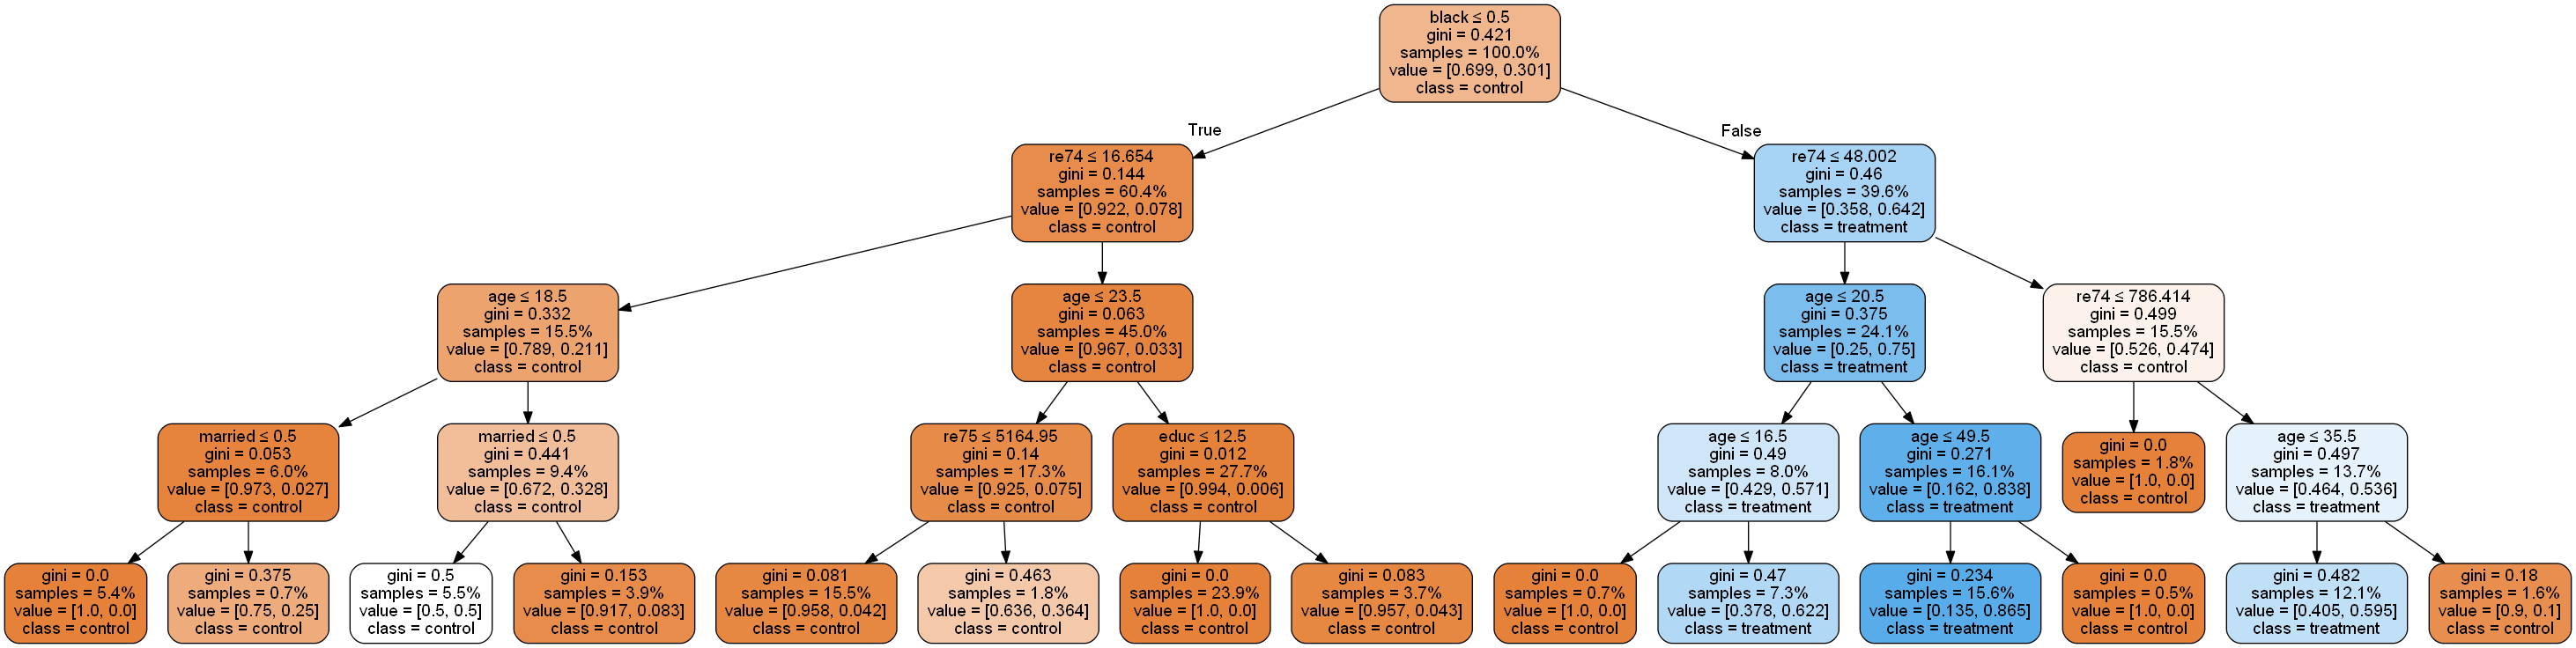

In [37]:
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image, SVG
from graphviz import Source

dot_data = StringIO()
export_graphviz(treeclf, out_file=dot_data, feature_names = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75'],
                class_names=['control','treatment'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

- For the first case, the tree would answer that this person is in the control group
- For the second case, the tree would answer that this person is in the control group

---------

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.**

In [38]:
clf_rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
clf_rf.fit(lalonde_df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']], lalonde_df['treat'])
pscore_forest=clf_rf.predict_proba(lalonde_df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']])[:,1]

---------

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.**

In [39]:
from sklearn.metrics import roc_curve, auc, accuracy_score

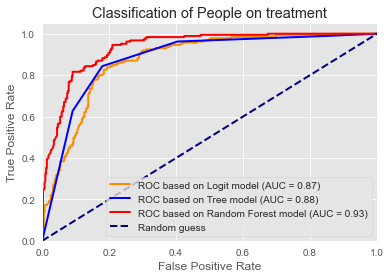

In [40]:
#Next we plot the ROC curve:
roc_vs = roc_curve(lalonde_df['treat'], pscore_logit['pscore'])
auc_vs = auc( roc_vs[0], roc_vs[1] )

roc_tr = roc_curve(lalonde_df['treat'], pscore_tree)
auc_tr = auc( roc_tr[0], roc_tr[1] )

roc_fo = roc_curve(lalonde_df['treat'], pscore_forest)
auc_fo = auc( roc_fo[0], roc_fo[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on Logit model (AUC = {auc_vs:0.2f})")
plt.plot(roc_tr[0], roc_tr[1], color='blue', lw=line_width,
         label=f"ROC based on Tree model (AUC = {auc_tr:0.2f})")
plt.plot(roc_fo[0], roc_fo[1], color='red', lw=line_width,
         label=f"ROC based on Random Forest model (AUC = {auc_fo:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of People on treatment')
plt.legend(loc='lower right')
plt.show()

Apparently random forest is the model that best classifies these groups, but we have to take into account overfiting problems by not dividing the dataframe between training and testing

---------

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

It is not totally true, there is a model such as the regression tree where it delivers fixed values of pscore which are repeated in certain leafs, this model could have a good AUC compared to another model, but at the time of matching it does not will give balanced covariates

---------

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.**

In [41]:
lalonde_copy['pscore_tree']=pscore_tree
lalonde_copy['pscore_forest']=pscore_forest
control_pscores_tree=lalonde_copy[lalonde_copy.treat==0].pscore_tree
control_pscores_forest=lalonde_copy[lalonde_copy.treat==0].pscore_forest
treat_pscores_forest=lalonde_copy[lalonde_copy.treat==1].pscore_forest
treat_pscores_tree=lalonde_copy[lalonde_copy.treat==1].pscore_forest

In [42]:
knn_tree = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn_tree.fit(np.array(control_pscores_tree).reshape(-1,1))
neigh=knn_tree.kneighbors(np.array(treat_pscores_tree).reshape(-1,1))[1]
matched_tree=pd.DataFrame()
for n in neigh:
    matched_tree=matched_tree.append(lalonde_df.loc[control_pscores_tree.iloc[[n[0]]].index[0]])
matched_tree

,age,black,educ,hispan,married,nodegree,re74,re75,re78,treat
PSID218,17.0,1.0,9.0,0.0,0.0,1.0,0.000,981.0968,8900.347,0.0
PSID31,22.0,0.0,13.0,1.0,0.0,0.0,6404.843,7882.7900,9453.017,0.0
PSID218,17.0,1.0,9.0,0.0,0.0,1.0,0.000,981.0968,8900.347,0.0
PSID368,40.0,1.0,11.0,0.0,1.0,1.0,0.000,0.0000,0.000,0.0
PSID218,17.0,1.0,9.0,0.0,0.0,1.0,0.000,981.0968,8900.347,0.0
...,...,...,...,...,...,...,...,...,...,...
PSID31,22.0,0.0,13.0,1.0,0.0,0.0,6404.843,7882.7900,9453.017,0.0
PSID31,22.0,0.0,13.0,1.0,0.0,0.0,6404.843,7882.7900,9453.017,0.0
PSID31,22.0,0.0,13.0,1.0,0.0,0.0,6404.843,7882.7900,9453.017,0.0
PSID31,22.0,0.0,13.0,1.0,0.0,0.0,6404.843,7882.7900,9453.017,0.0


In [43]:
t2, p2 = stats.ttest_ind(treatment.re78,matched_tree.re78)
print("t = " + str(t2))
print("p = " + str(p2))

t = 0.6421382498661233
p = 0.5211832300231862


In [44]:
names=treatment.columns[:-1]
asmd=pd.DataFrame()
for name in names:
    asmd[name]= [ASMD(treatment[name],control[name],matched_tree[name])]
asmd

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,inf,0.58408,0.072238,0.591177,0.108566,0.096138,0.079856,0.153124,0.035444,0.054551


With the matching that was performed we can see that now all the variables are balanced except for black and age

In [45]:
knn_forest = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn_forest.fit(np.array(control_pscores_forest).reshape(-1,1))
neigh=knn_forest.kneighbors(np.array(treat_pscores_forest).reshape(-1,1))[1]
matched_forest=pd.DataFrame()
for n in neigh:
    matched_forest=matched_forest.append(lalonde_df.loc[control_pscores_forest.iloc[[n[0]]].index[0]])
matched_forest

,age,black,educ,hispan,married,nodegree,re74,re75,re78,treat
PSID368,40.0,1.0,11.0,0.0,1.0,1.0,0.0000,0.000,0.0000,0.0
PSID48,25.0,1.0,12.0,0.0,1.0,0.0,295.8493,6942.871,461.0507,0.0
PSID423,27.0,1.0,10.0,0.0,0.0,1.0,0.0000,0.000,7543.7940,0.0
PSID423,27.0,1.0,10.0,0.0,0.0,1.0,0.0000,0.000,7543.7940,0.0
PSID416,34.0,1.0,12.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...
PSID96,47.0,1.0,10.0,0.0,0.0,1.0,21918.3200,4323.629,19438.0200,0.0
PSID140,19.0,1.0,9.0,0.0,0.0,1.0,1079.5560,2873.468,14344.2900,0.0
PSID140,19.0,1.0,9.0,0.0,0.0,1.0,1079.5560,2873.468,14344.2900,0.0
PSID99,28.0,1.0,12.0,0.0,0.0,0.0,16722.3400,4253.806,7314.7470,0.0


In [46]:
t2, p2 = stats.ttest_ind(treatment.re78,matched_forest.re78)
print("t = " + str(t2))
print("p = " + str(p2))

t = 1.0507646096358394
p = 0.29405623439808076


In [47]:
names=treatment.columns[:-1]
asmd=pd.DataFrame()
for name in names:
    asmd[name]= [ASMD(treatment[name],control[name],matched_forest[name])]
asmd

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,inf,0.120478,0.052537,0.154832,0.108566,0.108155,0.136896,0.123798,0.208844,0.101209


With the matching that was performed we can see that now all the variables are balanced except for re75

---------

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.**

---------

In [48]:
knn_tree_2 = neighbors.NearestNeighbors(n_neighbors=10,metric='euclidean')
knn_tree_2.fit(np.array(control_pscores_tree).reshape(-1,1))
knn_tree_2.kneighbors(np.array(treat_pscores_tree).reshape(-1,1))



(array([[0.01106948, 0.01106948, 0.01106948, ..., 0.01106948, 0.01106948,
         0.01106948],
        [0.11015369, 0.11015369, 0.11015369, ..., 0.11015369, 0.11015369,
         0.11015369],
        [0.11312981, 0.11312981, 0.11312981, ..., 0.11312981, 0.11312981,
         0.11312981],
        ...,
        [0.01549094, 0.01549094, 0.01549094, ..., 0.01549094, 0.01549094,
         0.01549094],
        [0.00157326, 0.00157326, 0.00157326, ..., 0.00157326, 0.00157326,
         0.00157326],
        [0.05360408, 0.05360408, 0.05360408, ..., 0.05360408, 0.05360408,
         0.05360408]]),
 array([[230, 255, 410, ..., 227, 217, 156],
        [345, 176, 175, ...,  30, 426,  83],
        [230, 255, 410, ..., 227, 217, 156],
        ...,
        [345, 176, 175, ...,  30, 426,  83],
        [345, 176, 175, ...,  30, 426,  83],
        [352, 155,  92, ...,  75, 152, 228]], dtype=int64))

In [49]:
pscore_tree

array([0.86458333, 0.5       , 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.86458333, 0.86458333, 0.08333333,
       0.62222222, 0.86458333, 0.62222222, 0.86458333, 0.62222222,
       0.62222222, 0.86458333, 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.5       , 0.5       , 0.86458333, 0.62222222,
       0.86458333, 0.86458333, 0.5       , 0.62222222, 0.86458333,
       0.62222222, 0.86458333, 0.86458333, 0.62222222, 0.86458333,
       0.86458333, 0.86458333, 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.5       , 0.62222222, 0.25      , 0.62222222,
       0.86458333, 0.62222222, 0.62222222, 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.62222222, 0.86458333, 0.86458333,
       0.62222222, 0.86458333, 0.86458333, 0.86458333, 0.5       ,
       0.62222222, 0.86458333, 0.86458333, 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.5       , 0.86458333, 0.86458333,
       0.86458333, 0.86458333, 0.62222222, 0.86458333, 0.86458

This model gives fixed values of pscore, that's why it makes many individuals look alike without their variables being very similar, that's why it causes problems when matching and trying to balance